In [1]:
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import math
import time
import pickle

import TransportationNetworks as tn
from heapq import heappush, heappop
from itertools import count

In [2]:
class Run:
    def __init__(self, link_file, trip_file, node_file, SO=True):
        
        nw = tn.Network(link_file, trip_file, node_file, SO)
        self.od_vols = nw.od_vols

        ## initialization
        self.network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
                   'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
                   'auxiliary':[], 'cost':[]} for (u, v, d) in nw.graph.edges(data=True)}
        
        self.fwResult = {'theta':[], 'z':[]}
        
        nw.all_or_nothing_assignment()
        nw.update_linkcost()
        
        for linkKey, linkVal in self.network.items():
            linkVal['cost'].append(nw.graph[linkKey[0]][linkKey[1]]['weight'])
            linkVal['auxiliary'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
            linkVal['flow'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
            
        ## iterations
        iterNum=0
        iteration = True
        start = time.time()
        PERIOD_OF_TIME = 900 # 15min

        while iteration:
            iterNum += 1
            nw.all_or_nothing_assignment()
            nw.update_linkcost()
            
            for linkKey, linkVal in self.network.items():
                linkVal['auxiliary'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
                
            theta = self.lineSearch()
            self.fwResult['theta'].append(theta)
            
            for linkKey, linkVal in self.network.items():
                aux = linkVal['auxiliary'][-1]
                flow = linkVal['flow'][-1]
                linkVal['flow'].append(flow + theta*(aux-flow))
                
                nw.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
                nw.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
                
            
            nw.update_linkcost()
            
            z=0
            for linkKey, linkVal in self.network.items():
                linkVal['cost'].append(nw.graph[linkKey[0]][linkKey[1]]['weight'])
                totalcost = nw.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
                z+=totalcost
                
            self.fwResult['z'].append(z)        
            
            if iterNum == 1:
                iteration = True
            else:
                print(iterNum)
                if abs(self.fwResult['z'][-2] - self.fwResult['z'][-1]) <= 0.001 or \
                   iterNum==1000 or \
                   time.time() > start + PERIOD_OF_TIME:
                    iteration = False
                
        print(iterNum, self.fwResult['z'][-1])
        self.graph = nw.graph
                    
    def BPR(self, t0, xa, ca, alpha, beta):
        ta = t0 * (1 + alpha * pow((xa/ca), beta))
        return ta
    
    def calculateZ(self, theta):
        z = 0
        for linkKey, linkVal in self.network.items():
            t0 = linkVal['t0']
            ca = linkVal['capa']
            beta = linkVal['beta']
            alpha = linkVal['alpha']
            aux = linkVal['auxiliary'][-1]
            flow = linkVal['flow'][-1]
            
            if SO == False:
                z += integrate.quad(lambda x: self.BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
            elif SO == True:
                z += list(map(lambda x : x * self.BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
        return z
    
    def lineSearch(self):
        theta = minimize_scalar(lambda x: self.calculateZ(x), bounds = (0,1), method = 'Bounded')
        return theta.x
    
    
    def shortest_successive_path(self, source, target, SO):
        if target == source:
            return [target]

        paths = {source: [source], target: []} # dictionary of paths
        G_succ = self.graph._succ
        push = heappush
        pop = heappop        
        dist = {}  # dictionary of final width
        c = count() # use the count c to avoid comparing nodes
        fringe = [] # fringe is min heapq with 3-tuples (distance,c,node)

        for n in self.graph.nodes:
            dist[n] = float('inf')
        dist[source] = 0
        
        push(fringe, (dist[source], next(c), source))
        while fringe:
            (w, _, v) = pop(fringe)
            if v == target:
                break

            for u, e in G_succ[v].items():
                # Check for only those edges who have enough capacity left
                if e['capacity'] > 0:
                    if SO == True:
                        dist_vu = e['weight']
                    else:
                        dist_vu = e['object'].length
                    alt = dist[v] + dist_vu

                    if alt < dist[u]:
                        dist[u] = alt
                        push(fringe, (dist[u], next(c), u))
                        paths[u] = paths[v] + [u]

        return paths[target]

    
    def showODPath(self, SO):
        capacity = dict()
        for (u, v, d) in self.graph.edges(data=True):
            capacity[(u,v)] = math.ceil(d['object'].vol)

        nx.set_edge_attributes(self.graph, capacity, name='capacity')

        # Decomposing flow into a path for every request
        infeasible = dict()
        cost = 0
        count = 0

        for ((origin, dest), demand) in self.od_vols.items():
            while demand > 0:
                path = self.shortest_successive_path(origin, dest, SO)

                if path == []: # Add to waiting queue
                    infeasible[(origin, dest)] = demand
                    break
                else:
                    # Decrement capacity of chosen path by 1
                    for i in range(len(path)-1):
                        u = path[i]
                        v = path[i+1]
                        self.graph[u][v]['capacity'] -= 1
                        cost += self.graph[u][v]['weight']
                    demand = demand - 1

        # Route infeasible paths in a user equilibrium way
        if len(infeasible) > 0:
            new_capacity = dict()

            for (u, v, d) in self.graph.edges(data=True):
                new_capacity[(u,v)] = d['object'].capacity -\
                                      math.ceil(d['object'].vol) +\
                                      d['capacity']

            nx.set_edge_attributes(self.graph, new_capacity, name='capacity')
            
            for (origin, dest), demand in infeasible.items():
                while demand > 0:
                    path = self.shortest_successive_path(origin, dest, SO)

                    if path == []: # Add to waiting queue
                        count += demand
                        break
                    else:
                        # Decrement capacity of chosen path by 1
                        for i in range(len(path)-1):
                            u = path[i]
                            v = path[i+1]
                            self.graph[u][v]['capacity'] -= 1
                            cost += self.graph[u][v]['weight']
                        demand = demand - 1   

        print("No. of infeasible trips:", count)
        print("Cost:", cost)
        return (count, cost)

In [3]:
node_file = '../data/TNTP/Singapore_node.tntp'

## Off-peak

In [4]:
link_file = '../data/TNTP/Singapore_net_off.tntp'
with open ('data/ped_off_2.pkl', 'rb') as fp:
    ped_off = pickle.load(fp)

In [5]:
# System Equilibrium = Multi-Class + System optimal flows + Congestion-aware routes
SO = True
trip_file = 'data/Singapore_trips_500_off_2.tntp'
fw = Run(link_file, trip_file, node_file, SO)

(s_count_off, s_cost_off) = fw.showODPath(SO)
s_cost_off += sum(ped_off)*5 - s_count_off*sum(ped_off)/100

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
70 4199915.153664102
No. of infeasible trips: 11.0
Cost: 7041733.609941025


In [6]:
# User Equilibrium = Single-Class + User optimal flows + Shortest-path routes
SO = False
trip_file = 'data/Singapore_trips_500_2.tntp'
fw = Run(link_file, trip_file, node_file, SO)
(u_count_off, u_cost_off) = fw.showODPath(SO)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
37 4203068.403777023
No. of infeasible trips: 48.0
Cost: 6663390.269392715


## Mod-peak

In [7]:
link_file = '../data/TNTP/Singapore_net_mod.tntp'
with open ('data/ped_mod_2.pkl', 'rb') as fp:
    ped_mod = pickle.load(fp)

In [8]:
# System Equilibrium
SO = True
trip_file = 'data/Singapore_trips_500_mod_2.tntp'
fw = Run(link_file, trip_file, node_file, SO)

(s_count_mod, s_cost_mod) = fw.showODPath(SO)
s_cost_mod += sum(ped_mod)*5 - s_count_mod*sum(ped_mod)/100

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
68 4434862.860433421
No. of infeasible trips: 28.0
Cost: 7568046.55531841


In [9]:
# User Equilibrium
SO = False
trip_file = 'data/Singapore_trips_500_2.tntp'
fw = Run(link_file, trip_file, node_file, SO)
(u_count_mod, u_cost_mod) = fw.showODPath(SO)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
36 4407828.931760645
No. of infeasible trips: 49.0
Cost: 7306677.958532812


## High-peak

In [10]:
link_file = '../data/TNTP/Singapore_net_high.tntp'
with open ('data/ped_high_2.pkl', 'rb') as fp:
    ped_high = pickle.load(fp)

In [11]:
# System Equilibrium
SO = True
trip_file = 'data/Singapore_trips_500_high_2.tntp'
fw = Run(link_file, trip_file, node_file, SO)

(s_count_high, s_cost_high) = fw.showODPath(SO)
s_cost_high += sum(ped_high)*5 - s_count_high*sum(ped_high)/100

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
73 4456619.324383585
No. of infeasible trips: 10.0
Cost: 7943646.624838443


In [12]:
# User Equilibrium
SO = False
trip_file = 'data/Singapore_trips_500_2.tntp'
fw = Run(link_file, trip_file, node_file, SO)
(u_count_high, u_cost_high) = fw.showODPath(SO)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
40 4438451.011510014
No. of infeasible trips: 47.0
Cost: 7541411.7317889035


## Plot!

In [52]:
import numpy as np

s_waiting_queue = [s_count_off, s_count_mod, s_count_high] 
u_waiting_queue = [u_count_off, u_count_mod, u_count_high]

# s_tt_cost = [s_cost_off, s_cost_mod, s_cost_high]
# u_tt_cost = [u_cost_off, u_cost_mod, u_cost_high]

s_tt_cost = [s_cost_off/((500-s_count_off)), s_cost_mod/((500-s_count_mod)), s_cost_high/((500-s_count_high))]
u_tt_cost = [u_cost_off/((500-u_count_off)), u_cost_mod/((500-u_count_mod)), u_cost_high/((500-u_count_high))]

labels = ["Off-Peak(12:00 A.M.)", "Moderately-Peak(3:00 P.M.)", "High-Peak(6:00 P.M.)"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

def autolabel(rects, ax, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(math.ceil(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom')

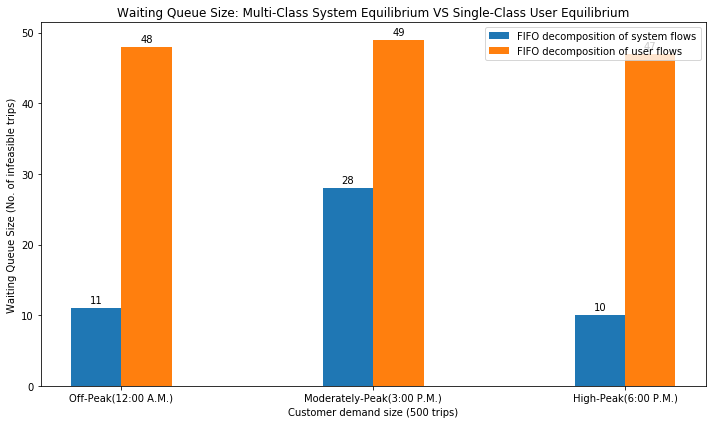

In [21]:
fig1, ax1 = plt.subplots(figsize=(10,6))
rects1 = ax1.bar(x - width/2, s_waiting_queue, width, label='FIFO decomposition of system flows')
rects2 = ax1.bar(x + width/2, u_waiting_queue, width, label='FIFO decomposition of user flows')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Waiting Queue Size (No. of infeasible trips)')
ax1.set_xlabel('Customer demand size (500 trips)')
ax1.set_title('Waiting Queue Size: Multi-Class System Equilibrium VS Single-Class User Equilibrium')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

autolabel(rects1, ax1)
autolabel(rects2, ax1)
fig1.tight_layout()

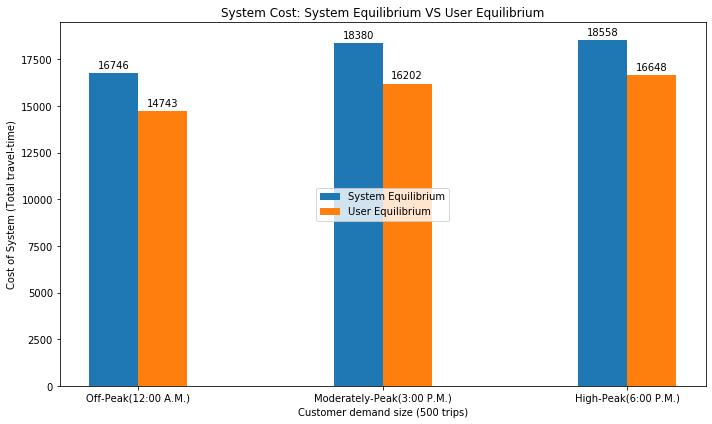

In [54]:
fig2, ax2 = plt.subplots(figsize=(10,6))
rects3 = ax2.bar(x - width/2, s_tt_cost, width, label='System Equilibrium')
rects4 = ax2.bar(x + width/2, u_tt_cost, width, label='User Equilibrium')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Cost of System (Total travel-time)')
ax2.set_xlabel('Customer demand size (500 trips)')
ax2.set_title('System Cost: System Equilibrium VS User Equilibrium')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='center')

autolabel(rects3, ax2)
autolabel(rects4, ax2)
fig2.tight_layout()

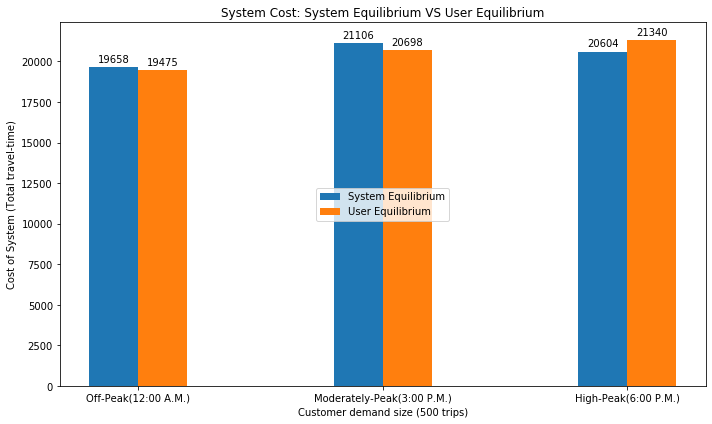

In [56]:
s = [(6308+16746+35918)/3, (7648+18380+37289)/3, (5708+18558+37545)/3]
u = [(10552+14743+33130)/3, (11144+16202+34747)/3, (11723+16648+35648)/3]

fig3, ax3 = plt.subplots(figsize=(10,6))
rects5 = ax3.bar(x - width/2, s, width, label='System Equilibrium')
rects6 = ax3.bar(x + width/2, u, width, label='User Equilibrium')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('Average Cost of System (Total travel-time)')
ax3.set_xlabel('Customer demand size (500 trips)')
ax3.set_title('System Cost: System Equilibrium VS User Equilibrium')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend(loc='center')

autolabel(rects5, ax3)
autolabel(rects6, ax3)
fig3.tight_layout()

In [60]:
(20604-21340)/60

-12.266666666666667